In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "2m_temperature"
date_range = ["1940-01-01", "2023-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

{'variable': ['2m_temperature'], 'date': ['1940-01-01/2023-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
2m_temperature_1940-01-01_2023-12-31_50.86_4.35.nc


2024-12-02 14:32:54,396 WARNING [2024-11-27T00:00:00] System is back on service under testing conditions. Please follow updates [here](https://forum.ecmwf.int/t/cds-ads-and-ewds-down-until-further-notice/8015) and status [here](https://status.ecmwf.int/)
2024-12-02 14:32:54,397 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-02 14:32:54,397 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-02 14:32:54,397 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-

Retrieving data in to:  2m_temperature_1940-01-01_2023-12-31_50.86_4.35.nc


In [2]:
# Make a function to compute the annual mean temperature time series
def temperatureAnnualTimeseries():
    """
    Processes temperature annual timeseries data.
    This function reads temperature data from a NetCDF file, removes incomplete
    years, resamples the data to annual means, and converts the temperature
    values from Kelvin to Celsius.
    Returns:
        tuple: A tuple containing:
            - years (numpy.ndarray): An array of years corresponding to the annual means.
            - abs_values (numpy.ndarray): An array of annual mean temperatures in Celsius.
    """

    print("Processing temperature annual timeseries")

    data = xr.open_dataset(data_file)
    data_t2m_pt = data.t2m

    # Remove incomplete year
    current_year = datetime.now().year
    timestamp_string = '{:d}-12-31 00:00:00'.format(current_year - 1)
    cutoff_date = pd.Timestamp(timestamp_string)
    data_t2m_pt_trun = data_t2m_pt.sel(valid_time=slice(None, cutoff_date))

    # Resample the data to annual means
    data_t2m_pt_agg = data_t2m_pt_trun.resample(valid_time="YE").mean()
    years = data_t2m_pt_agg.valid_time.to_index().year
    abs_values = (data_t2m_pt_agg - 273.15).values  # Convert from Kelvin to Celsius

    return (years, abs_values)

# Call our function
years1, ts1 = temperatureAnnualTimeseries()

Processing temperature annual timeseries


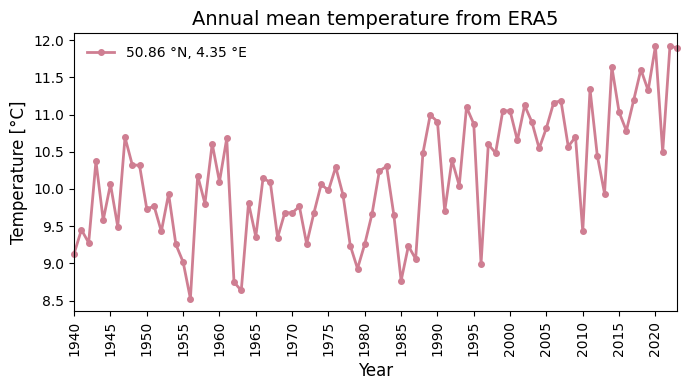

In [4]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

# Create a new figure
plt.figure(figsize=(7, 4))

# Plot the data
plt.plot(years1, ts1, marker=marker, markersize=markersize, label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}', color='#CF7E92', lw=lw, clip_on=False)

# Add legend
plt.legend(framealpha=0)

# Set x-ticks to appear every 10 years and rotate them
plt.xticks(np.arange(1940, 2100, 5), rotation=90)
plt.xlim(years1[0], years1[-1])

# Customize x and y axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)

# Add title with custom font
plt.title('Annual mean temperature from {:s}'.format(ERA_VERSION), fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()